In [2]:
import os
import zipfile
import tarfile
import subprocess
import rasterio
import numpy as np
from osgeo import gdal
from tabulate import tabulate
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

### 1. **Sentinal**

In [22]:
dir = r"sentinel"
img_path = [
    r"sentinel\S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206\S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.SAFE\GRANULE\L2A_T36UUA_A021740_20190821T085815\IMG_DATA",
    r"sentinel\S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206\S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.SAFE\GRANULE\L2A_T36UUB_A021740_20190821T085815\IMG_DATA"
]


In [24]:
for zip in os.listdir(dir):
    if zip.endswith(".zip"):
        zip_path = os.path.join(dir, zip)
        name = zip.replace(".zip", "")
        unzip_path = os.path.join(dir, name)
        if not os.path.exists(unzip_path):
            with zipfile.ZipFile(zip_path, 'r') as zip_ref:
                zip_ref.extractall(unzip_path)
                print(f"Розпаковано в {zip}")
        else:
            print(f"Вже розпаковано: {zip}")

for img in img_path:
    for s in ["R10m", "R20m", "R60m"]:
        sub_path = os.path.join(img, s)
        for n in os.listdir(sub_path):
            parts = n.split('_')
            name = '_'.join(parts[-2:])
            old_path = os.path.join(sub_path, n)
            new_path = os.path.join(sub_path, name)
            if not os.path.exists(new_path):
                os.rename(old_path, new_path)
                print(f" {n} → {name}")
            else:
                print(f"Вже перейменовано -> {name}")


Вже розпаковано: S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.zip
Вже розпаковано: S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.zip
Вже перейменовано -> AOT_10m.jp2
Вже перейменовано -> B02_10m.jp2
Вже перейменовано -> B03_10m.jp2
Вже перейменовано -> B04_10m.jp2
Вже перейменовано -> B08_10m.jp2
Вже перейменовано -> TCI_10m.jp2
Вже перейменовано -> WVP_10m.jp2
Вже перейменовано -> AOT_20m.jp2
Вже перейменовано -> B02_20m.jp2
Вже перейменовано -> B03_20m.jp2
Вже перейменовано -> B04_20m.jp2
Вже перейменовано -> B05_20m.jp2
Вже перейменовано -> B06_20m.jp2
Вже перейменовано -> B07_20m.jp2
Вже перейменовано -> B11_20m.jp2
Вже перейменовано -> B12_20m.jp2
Вже перейменовано -> B8A_20m.jp2
Вже перейменовано -> SCL_20m.jp2
Вже перейменовано -> TCI_20m.jp2
Вже перейменовано -> WVP_20m.jp2
Вже перейменовано -> AOT_60m.jp2
Вже перейменовано -> B01_60m.jp2
Вже перейменовано -> B02_60m.jp2
Вже перейменовано -> B03_60m.jp2
Вже перейменовано -> B04_60m.jp2
Вже перейме

In [1]:
python_exe = r".venv\Scripts\python.exe"
gdal_merge = r".venv\Scripts\gdal_merge.py"
gdal_pans = r".venv\Scripts\gdal_pansharpen.py"
shape = r"sentinel\Kyiv_regions.shp"
res_dir = r"sentinel_result"
band_path = {
    "UUA": r"sentinel\S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206\S2A_MSIL2A_20190821T085601_N0213_R007_T36UUA_20190821T115206.SAFE\GRANULE\L2A_T36UUA_A021740_20190821T085815\IMG_DATA\R10m",
    "UUB": r"sentinel\S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206\S2A_MSIL2A_20190821T085601_N0213_R007_T36UUB_20190821T115206.SAFE\GRANULE\L2A_T36UUB_A021740_20190821T085815\IMG_DATA\R10m"
}
band = ['B02_10m.jp2', 'B03_10m.jp2', 'B04_10m.jp2', 'B08_10m.jp2']

In [5]:

os.makedirs(res_dir, exist_ok=True)
def merge_reproject(tile, dir):
    band_path = [os.path.join(dir, n) for n in band]
    merged = os.path.join(res_dir, f"merged_{tile}.tif")
    re = os.path.join(res_dir, f"rep_{tile}.tif")
    
    subprocess.run([python_exe, gdal_merge, "-o", merged, "-separate"] + band_path)
    print(f"Об'єднано канали в {merged}")

    subprocess.run(["gdalwarp", "-t_srs", "EPSG:4326", merged, re])
    print(f"Перепроєктовано в {re}")
    return re

rep_tiles = [merge_reproject(i, path) for i, path in band_path.items()]
 
tw_path = os.path.join(res_dir, "cat.tif")
subprocess.run([python_exe, gdal_merge, "-o", tw_path,] + rep_tiles)
print(f"Об'єднано в {tw_path}")

clip_path = os.path.join(res_dir, "clipped.tif")
subprocess.run([
    "gdalwarp",
    "-cutline", shape,
    "-crop_to_cutline",
    "-dstnodata", "0",
    "-of", "GTiff",
    tw_path,
    clip_path])
print(f"Обрізано по векторному контуру в {clip_path}")


[✔] Об'єднано канали в sentinel_result\merged_UUA.tif
[✔] Перепроєктовано в sentinel_result\rep_UUA.tif
[✔] Об'єднано канали в sentinel_result\merged_UUB.tif
[✔] Перепроєктовано в sentinel_result\rep_UUB.tif
[✔] Об'єднано в sentinel_result\cat.tif
[✔] Обрізано по векторному контуру в sentinel_result\clipped.tif


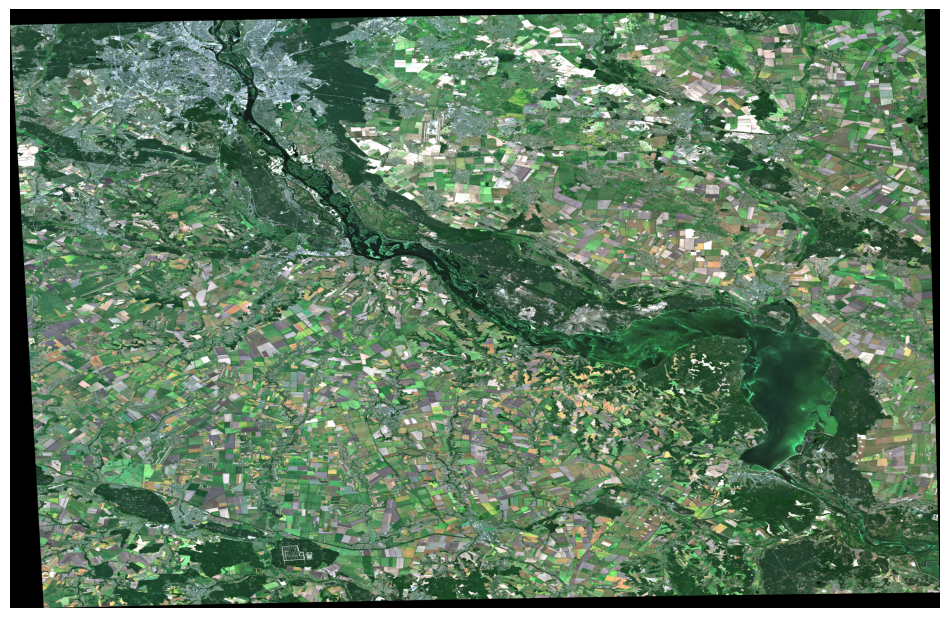

In [3]:
with rasterio.open(r"sentinel_result\rep_UUA.tif") as src:
    rgb = src.read([3, 2, 1]) 
    def normalize(channel):
        p2, p98 = np.percentile(channel, (2, 98))
        return np.clip((channel - p2) / (p98 - p2), 0, 1)
    rgb_norm = np.stack([normalize(band) for band in rgb])
    plt.figure(figsize=(12, 8))  
    plt.imshow(rgb_norm.transpose(1, 2, 0))
    plt.axis("off")
    plt.show()


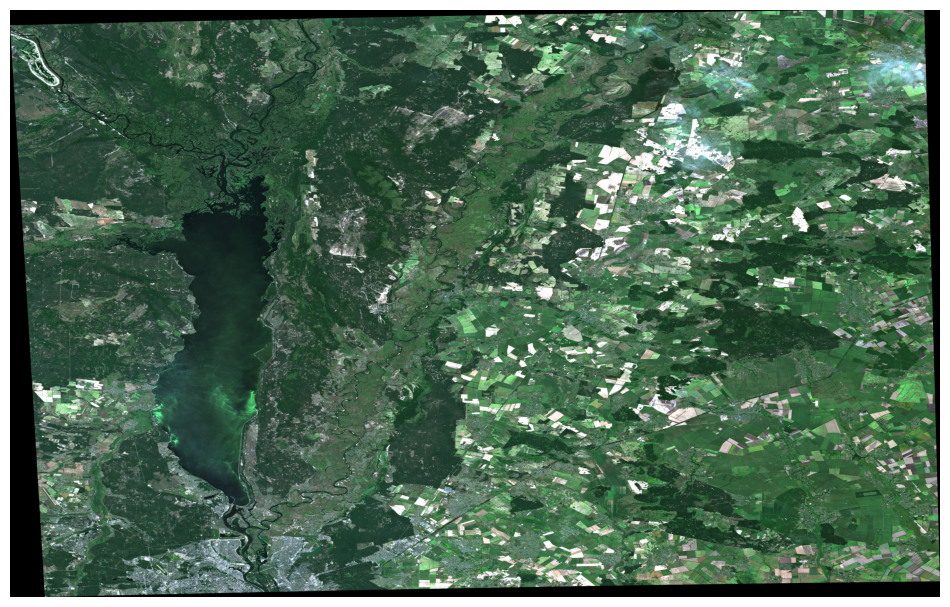

In [8]:
with rasterio.open(r"sentinel_result\rep_UUB.tif") as src:
    rgb = src.read([3, 2, 1]) 
    def normalize(channel):
        p2, p98 = np.percentile(channel, (2, 98))
        return np.clip((channel - p2) / (p98 - p2), 0, 1)
    rgb_norm = np.stack([normalize(band) for band in rgb])
    plt.figure(figsize=(12, 8))  
    plt.imshow(rgb_norm.transpose(1, 2, 0))
    plt.axis("off")
    plt.show()


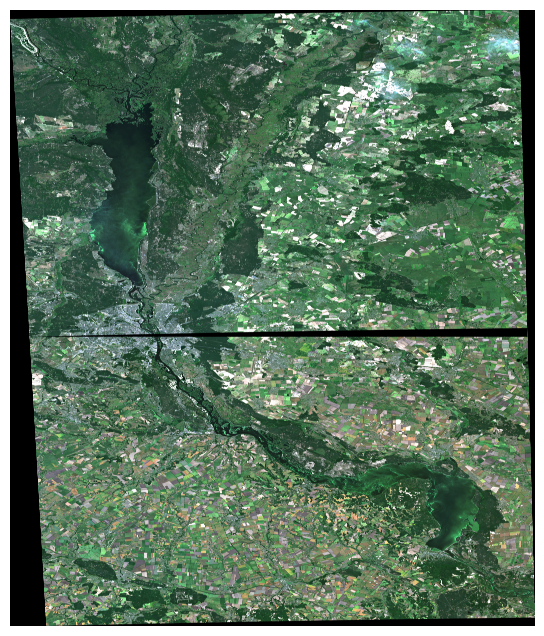

In [4]:
with rasterio.open(r"sentinel_result\cat.tif") as src:
    rgb = src.read([3, 2, 1]) 
    def normalize(channel):
        p2, p98 = np.percentile(channel, (2, 98))
        return np.clip((channel - p2) / (p98 - p2), 0, 1)
    rgb_norm = np.stack([normalize(band) for band in rgb])
    plt.figure(figsize=(12, 8))  
    plt.imshow(rgb_norm.transpose(1, 2, 0))
    plt.axis("off")
    plt.show()


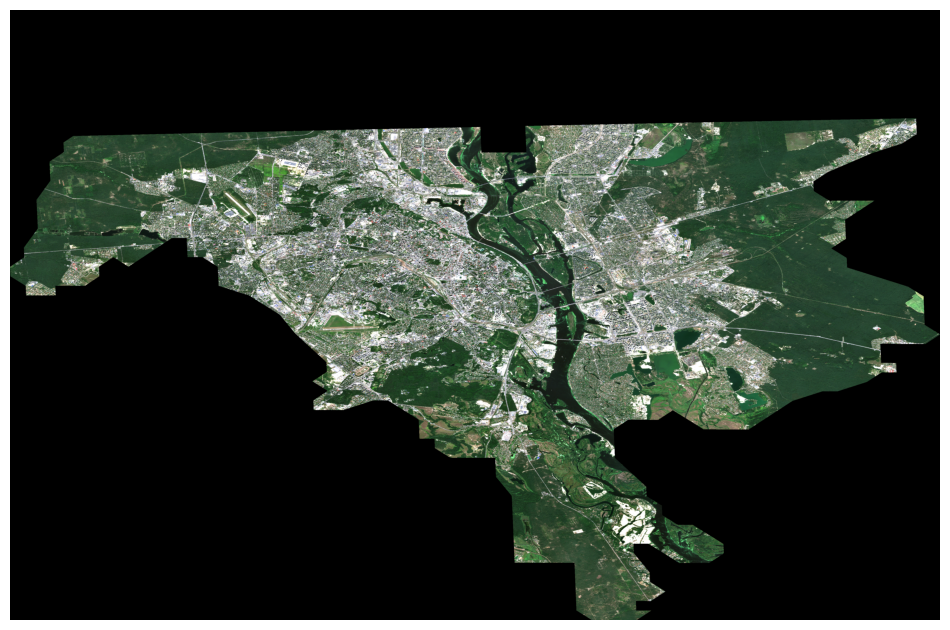

In [5]:
with rasterio.open(r"sentinel_result\clipped.tif") as src:
    rgb = src.read([3, 2, 1]) 
    def normalize(channel):
        p2, p98 = np.percentile(channel, (2, 98))
        return np.clip((channel - p2) / (p98 - p2), 0, 1)
    rgb_norm = np.stack([normalize(band) for band in rgb])
    plt.figure(figsize=(12, 8))  
    plt.imshow(rgb_norm.transpose(1, 2, 0))
    plt.axis("off")
    plt.show()


### 2. **Landsat**

In [25]:
python = r".venv\Scripts\python.exe"
gdal_merge = r".venv\Scripts\gdal_merge.py"
gdal_pans = r".venv\Scripts\gdal_pansharpen.py"
landsat = r"landsat\unzip"
res1_dir = r"landsat_result"
tar_path = r"landsat\LC08_L1TP_182025_20250424_20250429_02_T1.tar"

In [26]:
os.makedirs(res1_dir, exist_ok=True)
if not os.path.exists(landsat):
    with tarfile.open(tar_path, "r") as tar:
        tar.extractall(path=landsat)
        print(f"Архів розпаковано в {landsat}")
else:
    print(f"Вже розпаковано в {landsat}")

for f in os.listdir(landsat):
    src = os.path.join(landsat, f)
    if os.path.isfile(src):
        new = f.split('_')[-1]
        dst = os.path.join(landsat, new)
        if f != new:
            os.rename(src, dst)
            print(f" {f} -> {new}")
        else:
            print(f"Вже перейменовано -> {f}")


Вже розпаковано в landsat\unzip
Вже перейменовано: ANG.txt
Вже перейменовано: B1.TIF
Вже перейменовано: B10.TIF
Вже перейменовано: B11.TIF
Вже перейменовано: B2.TIF
Вже перейменовано: B3.TIF
Вже перейменовано: B4.TIF
Вже перейменовано: B5.TIF
Вже перейменовано: B6.TIF
Вже перейменовано: B7.TIF
Вже перейменовано: B8.TIF
Вже перейменовано: B9.TIF
Вже перейменовано: large.jpeg
Вже перейменовано: MTL.json
Вже перейменовано: MTL.txt
Вже перейменовано: MTL.xml
Вже перейменовано: PIXEL.TIF
Вже перейменовано: RADSAT.TIF
Вже перейменовано: SAA.TIF
Вже перейменовано: small.jpeg
Вже перейменовано: stac.json
Вже перейменовано: SZA.TIF
Вже перейменовано: VAA.TIF
Вже перейменовано: VZA.TIF


In [27]:

band = ["B2.TIF", "B3.TIF", "B4.TIF"]
band_path = [os.path.join(landsat, b) for b in band]
pan = os.path.join(landsat, "B8.TIF")

rgb_merged = os.path.join(res1_dir, "rgb.tif")
subprocess.run([python, gdal_merge, "-separate", "-o", rgb_merged] + band_path)
print(f"Об'єднано RGB канали у: {rgb_merged}")

pan_30m = os.path.join(res1_dir, "pan_30m.tif")
subprocess.run([
    "gdal_translate", "-tr", "30", "30", "-r", "cubic",
    pan, pan_30m
], check=True)
print(f"Переведено панхроматичний канал до 30м: {pan_30m}")

rgb_60m = os.path.join(res1_dir, "rgb_60m.tif")
subprocess.run([
    "gdal_translate", "-tr", "60", "60", "-r", "cubic",
    rgb_merged, rgb_60m
], check=True)
print(f"Знижено роздільність RGB до 60м: {rgb_60m}")

methods = ["nearest", "bilinear", "cubic", "cubicspline", "lanczos", "average"]
sharpened = {}

for m in methods:
    out = os.path.join(res1_dir, f"pansharpened_{m}.tif")
    subprocess.run([python, gdal_pans, "-r", m, pan_30m, rgb_60m, out])
    sharpened[m] = out
    print(f"Паншарпенінг методом {m}: {out}")

Об'єднано RGB канали у: landsat_result\rgb.tif
Переведено панхроматичний канал до 30м: landsat_result\pan_30m.tif
Знижено роздільність RGB до 60м: landsat_result\rgb_60m.tif
Паншарпенінг методом nearest: landsat_result\pansharpened_nearest.tif
Паншарпенінг методом bilinear: landsat_result\pansharpened_bilinear.tif
Паншарпенінг методом cubic: landsat_result\pansharpened_cubic.tif
Паншарпенінг методом cubicspline: landsat_result\pansharpened_cubicspline.tif
Паншарпенінг методом lanczos: landsat_result\pansharpened_lanczos.tif
Паншарпенінг методом average: landsat_result\pansharpened_average.tif


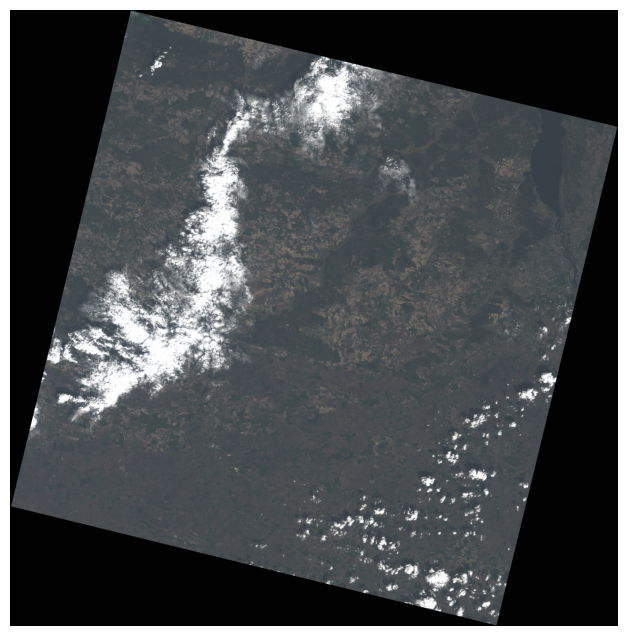

In [28]:
with rasterio.open(r"landsat_result\rgb.tif") as src:
    rgb = src.read([3, 2, 1])
    
    def normalize(channel):
        p2, p98 = np.percentile(channel, (2, 98))
        return np.clip((channel - p2) / (p98 - p2), 0, 1)
    rgb_norm = np.stack([normalize(band) for band in rgb])
    plt.figure(figsize=(12, 8))
    plt.imshow(rgb_norm.transpose(1, 2, 0))
    plt.axis("off")
    plt.show()

In [40]:

def metrics(original, sharpened):    
    metric = {
        'r2_score': [],
        'rmse': [],
        'mae': []
    }

    for i in range(original.shape[0]):
        orig_band = original[i].flatten()
        sharp_band = sharpened[i].flatten()
                
        metric['r2_score'].append(r2_score(orig_band, sharp_band))
        metric['rmse'].append(np.sqrt(mean_squared_error(orig_band, sharp_band)))
        metric['mae'].append(mean_absolute_error(orig_band, sharp_band))
        
    for i in metric:
        metric[i] = np.mean(metric[i])
    return metric

def read(path):
    ds = gdal.Open(path)
    bands = []
    for i in range(1, ds.RasterCount + 1):
        band = ds.GetRasterBand(i)
        bands.append(band.ReadAsArray())
    return np.array(bands)

original = read(rgb_merged)
results = {}
for method, output_path in sharpened.items():
    pans_rgb = read(output_path)
    metric = metrics(original, pans_rgb)
    results[method] = metric



In [52]:
data = []
for method, metric in results.items():
    data.append([
        method, 
        f"{metric['r2_score']:.4f}", 
        f"{metric['rmse']:.4f}", 
        f"{metric['mae']:.4f}"
    ])

headers = ["Метод", "R² ↑", "RMSE ↓", "MAE ↓"]
print(tabulate(data, headers=headers, tablefmt="double_outline"))

best_r2 = max(results, i=lambda x: results[x]['r2_score'])
best_rmse = min(results, i=lambda x: results[x]['rmse'])
best_mae = min(results, i=lambda x: results[x]['mae'])

print(f"За R² (вищий краще): {best_r2} (R² = {results[best_r2]['r2_score']:.4f})")
print(f"За RMSE (нижчий краще): {best_rmse} (RMSE = {results[best_rmse]['rmse']:.4f})")
print(f"За MAE (нижчий краще): {best_mae} (MAE = {results[best_mae]['mae']:.4f})")

╔═════════════╦════════╦══════════╦═════════╗
║ Метод       ║   R² ↑ ║   RMSE ↓ ║   MAE ↓ ║
╠═════════════╬════════╬══════════╬═════════╣
║ nearest     ║ 0.9947 ║  497.288 ║ 262.32  ║
║ bilinear    ║ 0.9933 ║  559.515 ║ 265.173 ║
║ cubic       ║ 0.9941 ║  525.66  ║ 262.497 ║
║ cubicspline ║ 0.9926 ║  586.182 ║ 268.316 ║
║ lanczos     ║ 0.9941 ║  525.085 ║ 262.478 ║
║ average     ║ 0.9937 ║  538.994 ║ 263.947 ║
╚═════════════╩════════╩══════════╩═════════╝
За R² (вищий краще): nearest (R² = 0.9947)
За RMSE (нижчий краще): nearest (RMSE = 497.2882)
За MAE (нижчий краще): nearest (MAE = 262.3205)
